1.0
1.0


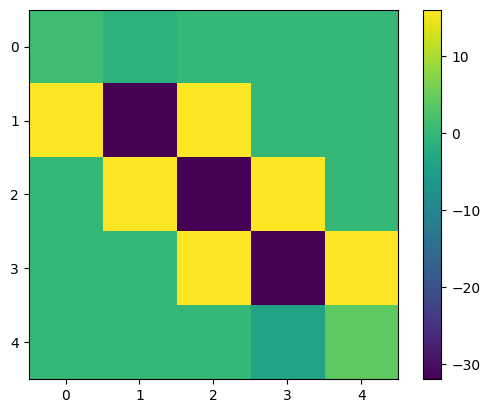

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def solve_bvp(N):
    h = 1.0 / N
    x = np.linspace(0, 1, N+1)

    # Matrix A and RHS b
    A = np.zeros((N+1, N+1))
    b = np.ones(N+1)

    # Interior points
    for i in range(1, N):
        A[i, i-1] = 1.0 / h**2
        A[i, i]   = -2.0 / h**2
        A[i, i+1] = 1.0 / h**2
        b[i] = 1.0  # from u''=1

    # Neumann BC at x=0: u'(0)=0  → (u1 - u_{-1})/(2h)=0 → u0 - u1 = 0
    A[0,0] = 1.0
    A[0,1] = -1.0
    b[0] = 0.0

    # Neumann BC at x=1: u'(1)=1 → (u_{N+1} - u_{N-1})/(2h)=1
    # Approximate with (uN - u_{N-1})/h = 1  (second-order one-sided)
    A[N,N]   = 1.0 / h
    A[N,N-1] = -1.0 / h
    b[N] = 1.0

    # Add integral constraint as last equation
    # A = np.vstack([A, np.ones(N+1)*h])
    # b = np.append(b, 1.0)

    plt.imshow(A)
    plt.colorbar()

    # Solve least squares (since extra eqn makes system overdetermined)
    u, *_ = np.linalg.lstsq(A, b, rcond=None)

    return x, u
from scipy.integrate import simpson
n=4
x,u = solve_bvp(n)
u /= simpson(u,x)  # Normalize
print(simpson(u,x))
x = np.linspace ( 0. , 1. , n+1 )
an =  0.5*x**2+5/6
# an /= simpson(an)
print(simpson(an,x))
# plt.plot( x , 0.5*x**2+5/6 ,label='Analytic');
# plt.plot(x,u);
# plt.legend()